In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.colors import TwoSlopeNorm

In [2]:
sns.set_theme()

def resample_returns(df_returns, frequency='Q'):
    """
    Resample the monthly returns DataFrame to the specified frequency.

    Parameters:
        df_returns (DataFrame): DataFrame containing monthly returns.
        frequency (str): Frequency to resample the data to. 'A' for annually, 'Q' for quarterly.

    Returns:
        DataFrame: Resampled DataFrame based on the specified frequency.
    """
    # change index to datetime
    df_returns.index = pd.to_datetime(df_returns.index)

    # check to see if df_returns.index[0] is a calendar year-end
    if not df_returns.index[0].month in [1 ,4, 7, 10]:
        # Find the index of the next data point with a month in [1, 4, 7, 10]
        next_quarter_start = df_returns.index[df_returns.index.month.isin([1, 4, 7, 10])][0]

        # Create a new df_returns dataframe that starts at the next datapoint with a month in [1, 4, 7, 10]
        df_returns_new = df_returns[next_quarter_start:]
    else:
        df_returns_new = df_returns.copy()


    if frequency == 'Q':
        # resample to quarterly, geometrically linking the returns
        return (1 + df_returns_new).resample('Q').prod() - 1

    elif frequency == 'A':
        # resample to annually, geometrically linking the returns
        return (1 + df_returns_new).resample('A').prod() - 1
    else:
        raise ValueError("Invalid frequency. Choose 'A' for annual or 'Q' for quarterly.")

def create_heatmap(df_returns, frequency='M', ticker=None):
    """
    Create a heatmap of returns.

    Parameters:
        df_returns (DataFrame): DataFrame containing returns.
            Index should be DateTimeIndex.
        frequency (str): Frequency to resample the data to. 'M' for monthly, 'Q' for quarterly.
        ticker (str): Ticker to include in the graph title. Default is None.

    Returns:
        None (displays the heatmap)
    """

    if ticker:
        title = f'{ticker} Returns Heatmap (%)'
    else:
        title = 'Returns Heatmap (%)'

    if frequency == 'M':
        pivot_df = df_returns.pivot_table(index=df_returns.index.year, columns=df_returns.index.month,
                                          values=df_returns.columns[0], aggfunc='sum')
        pivot_df = pivot_df.reindex(columns=range(1, 13))
        x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    elif frequency == 'Q':
        # Resample monthly returns to quarterly
        df_returns_qtr = resample_returns(df_returns, 'Q')
        pivot_df = df_returns_qtr.pivot_table(index=df_returns_qtr.index.year, columns=df_returns_qtr.index.quarter,
                                              values=df_returns_qtr.columns[0], aggfunc='sum')
        pivot_df = pivot_df.reindex(columns=[1, 2, 3, 4])
        x_labels = ['Q1', 'Q2', 'Q3', 'Q4']
    else:
        raise ValueError("Invalid frequency. Choose 'M' for monthly or 'Q' for quarterly.")

    cmap_colors = [(1, 0, 0),  # dark red
                   (1, 0.5, 0.5),  # light red
                   (0.5, 1, 0.5),  # light green
                   (0, 1, 0)]  # dark green
    cmap = sns.mpl.colors.ListedColormap(cmap_colors)

    # Find the maximum absolute value for normalization
    vmax = pivot_df.abs().max().max() * 100
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

    fig, ax = plt.subplots(figsize=(12, 8))
    heatmap = sns.heatmap(pivot_df[::-1].mul(100).round(2), cmap=cmap, annot=True, fmt=".2f", linewidths=.5,
                          ax=ax, norm=norm)  # Invert y-axis with [::-1]

    ax.set_title(title)
    ax.set_xlabel('Month' if frequency == 'M' else 'Quarter')
    ax.set_ylabel('Year')
    ax.set_xticks(np.arange(len(x_labels)) + 0.5)
    ax.set_xticklabels(x_labels)
    ax.tick_params(axis='x', pad=10)  # Adjust the padding between ticks and labels
    plt.yticks(rotation=0)

    plt.show()

[*********************100%***********************]  1 of 1 completed

C:\Users\Wonyoung\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


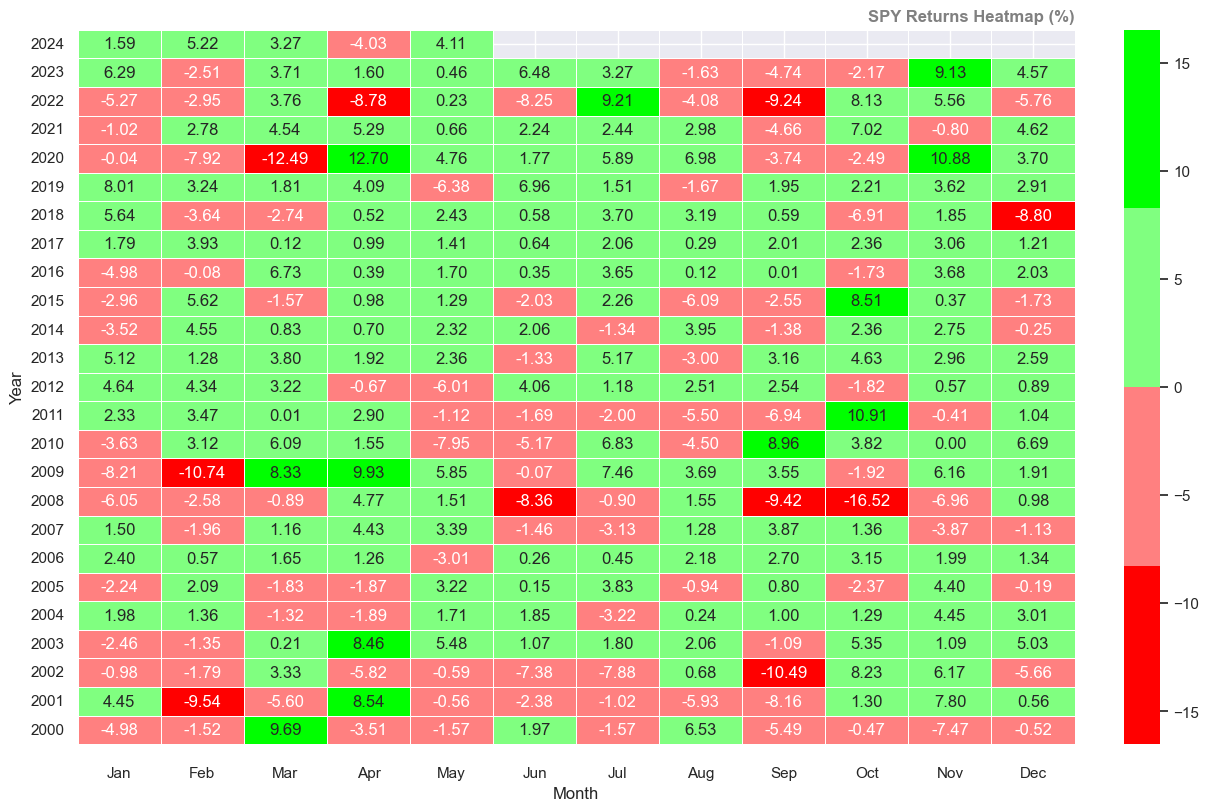

C:\Users\Wonyoung\AppData\Local\Temp\ipykernel_23076\186257512.py:30: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  return (1 + df_returns_new).resample('Q').prod() - 1


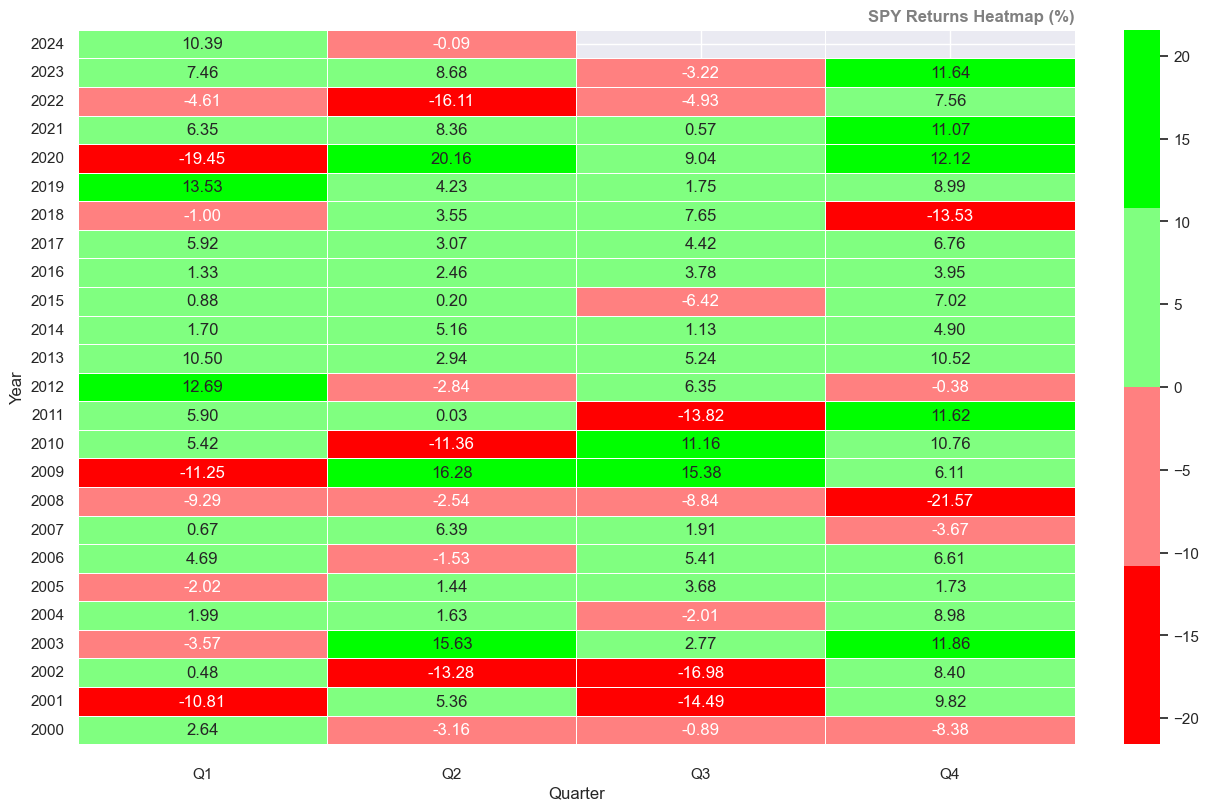

In [3]:
# retrieve the prices, resample to monthly
start_date = '1999-12-31'
end_date = '2024-05-31'
ticker = 'SPY'

df_prices = yf.download(ticker, start_date, end_date)[['Adj Close']]
df_prices.index = pd.to_datetime(df_prices.index)
df_prices = df_prices.resample('ME').last()
df_returns = df_prices.pct_change().dropna()

# Call the function to create the heatmap for monthly returns
create_heatmap(df_returns, frequency='M', ticker=ticker)

# Call the function to create the heatmap for quarterly returns
create_heatmap(df_returns, frequency='Q', ticker=ticker)